# Mining Kickstarter Data: Analysis and Prediction

<img src="https://vignette.wikia.nocookie.net/tomba/images/2/20/Kickstarter-logo.png/revision/latest?cb=20151211134237">

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading / Preprocessing

Let's load the data and see what type of features we're dealing with.

In [3]:
#The last few columns of the CSV from Kaggle are blank, so we'll ignore them
kick = pd.read_csv("ksprojects.csv", usecols=range(13))

In [4]:
kick.dtypes

ID                 int64
name              object
category          object
main_category     object
currency          object
deadline          object
goal              object
launched          object
pledged           object
state             object
backers           object
country           object
usd pledged       object
dtype: object

In [5]:
kick.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375


There's a bunch of whitespace in a few of the column heads, so we'll need to remove that first.

In [6]:
kick.rename(columns=lambda x: x.strip(), inplace=True)

Let's also convert some of the date/numeric columns to their proper data type.

There seems to be a few rows that weren't entered correctly, and we need to remove them. We can set the error parameter in the pd.to_datetime or pd.to_numeric functions to coerce, which will set the value as NaN. Then we can remove all Null values from the dataframe.

In [7]:
#Convert the deadline and launched dates to datetime objects
kick['deadline'] = pd.to_datetime(kick['deadline'], errors='coerce')
kick['launched'] = pd.to_datetime(kick['launched'], errors='coerce')

In [8]:
#Convert the goal, pledged, and backers columns to numeric
kick['goal'] = pd.to_numeric(kick['goal'], errors='coerce')
kick['pledged'] = pd.to_numeric(kick['pledged'], errors='coerce')
kick['usd pledged'] = pd.to_numeric(kick['usd pledged'], errors='coerce')
kick['backers'] = pd.to_numeric(kick['backers'], errors='coerce')

In [9]:
#Check that everything worked smoothly
kick.dtypes

ID                        int64
name                     object
category                 object
main_category            object
currency                 object
deadline         datetime64[ns]
goal                    float64
launched         datetime64[ns]
pledged                 float64
state                    object
backers                 float64
country                  object
usd pledged             float64
dtype: object

In [10]:
#Now, drop all of the rows that have NaN in them
print("Pre-drop: " + str(len(kick)))
kick.dropna(inplace=True)
print("Post-drop: " + str(len(kick)))

Pre-drop: 323750
Post-drop: 319324


## Basic Analysis and Visualization

Before running prediction, let's explore the data. We'll start with some summary visualizations.

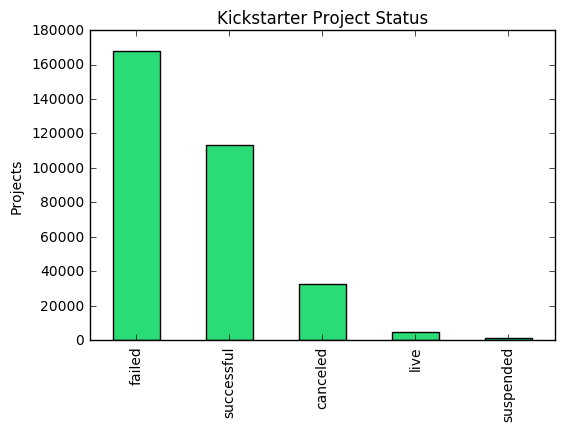

In [11]:
#Distribution of project status
kick['state'].value_counts().plot(kind='bar', color='#2ADC75')
plt.title('Kickstarter Project Status')
plt.ylabel('Projects')

In this dataset, the plurality of projects failed, and a non-trivial amount were cancelled. Very few are live or suspended.

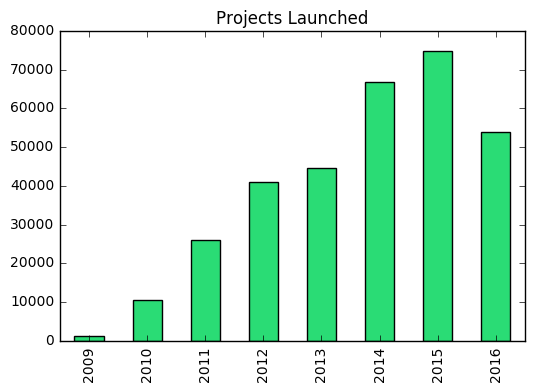

In [12]:
#Projects over time
kickTime = kick.copy()
kickTime.set_index('launched', inplace=True)
grouped = kickTime.resample("A").agg({'ID': np.size})
grouped.index = grouped.index.year
grouped.iloc[len(grouped)-8:len(grouped)].plot(kind='bar', color='#2ADC75', legend=None)
plt.title('Projects Launched')
plt.xlabel('')

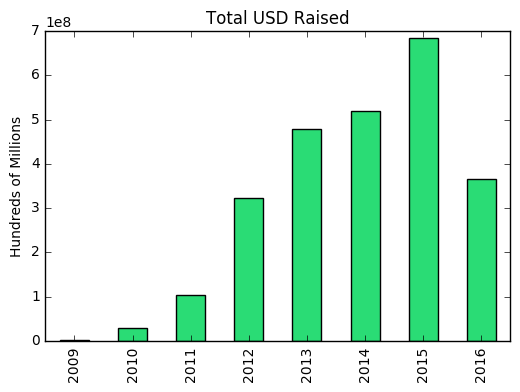

In [13]:
#Dollar value over time
grouped = kickTime.resample("A").agg({'usd pledged': np.sum})
grouped.index = grouped.index.year
grouped.iloc[len(grouped)-8:len(grouped)].plot(kind='bar', color='#2ADC75', legend=None)
plt.title('Total USD Raised')
plt.xlabel('')
plt.ylabel('Hundreds of Millions')

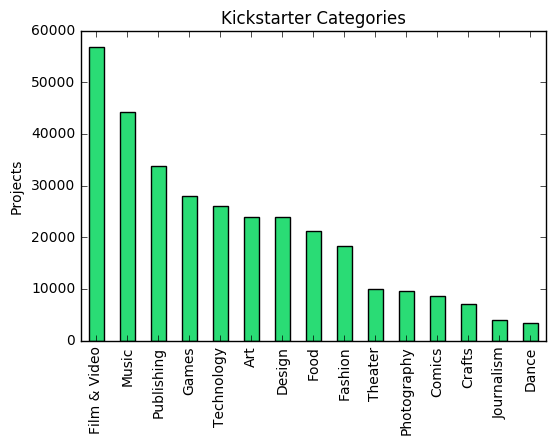

In [14]:
#Distribution of main categories
kick['main_category'].value_counts().plot(kind='bar', color='#2ADC75')
plt.title('Kickstarter Categories')
plt.ylabel('Projects')

The arts (Film, Video, Music) are the most popular categories. Technology is only 5th, which is surprising given how much those kinds of projects grab the news headlines.

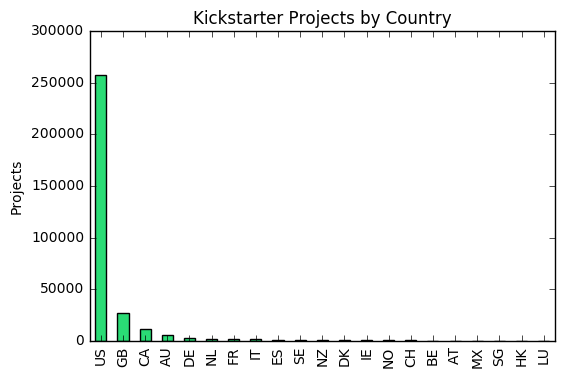

In [15]:
#Distribution of countries
kick['country'].value_counts().plot(kind='bar', color='#2ADC75')
plt.title('Kickstarter Projects by Country')
plt.ylabel('Projects')

English speaking companies totally dominate. 

In [16]:
#Distribution of goals
pd.set_option('display.float_format', lambda x: '%.2f' % x)
kick['goal'].describe()

count      319324.00
mean        47647.73
std       1146310.93
min             0.01
25%          2000.00
50%          5000.00
75%         15000.00
max     100000000.00
Name: goal, dtype: float64

The average goal is around 50K, but the standard deviation is more than 1M – and the median is 5K. Let's check out how these compare to the actual amount pledged.

In [17]:
kick['pledged'].describe()

count     319324.00
mean        8764.17
std        89981.71
min            0.00
25%           30.00
50%          610.00
75%         3939.81
max     20338986.27
Name: pledged, dtype: float64

These numbers are noticeably lower across the board. We can get a sense for how succesful each project generally is by creating a pledged/goal ratio on a per group basis. First, across state:

In [18]:
stateRatio = kick.groupby('state').agg({'pledged': np.mean, 'goal': np.mean})
stateRatio['ratio'] = stateRatio['pledged'] / stateRatio['goal']
stateRatio

,pledged,goal,ratio
state,,,
canceled,2287.62,88041.61,0.03
failed,1369.41,63500.80,0.02
live,11778.96,64125.41,0.18
successful,21480.74,9627.80,2.23
suspended,10485.76,217884.25,0.05


Now, across categories:

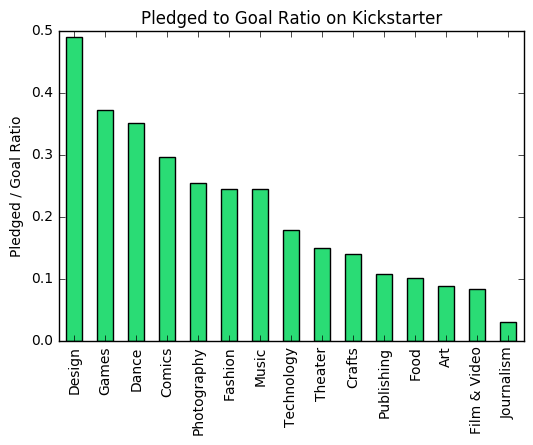

In [19]:
catRatio = kick.groupby('main_category').agg({'pledged': np.mean, 'goal': np.mean})
catRatio['ratio'] = catRatio['pledged'] / catRatio['goal']
catRatio['ratio'].sort_values(ascending=False).plot(kind='bar', color='#2ADC75')
plt.title('Pledged to Goal Ratio on Kickstarter')
plt.xlabel('')
plt.ylabel('Pledged / Goal Ratio')

We can do the same analysis with succesful to failed projects to get a more macro feel for each category.

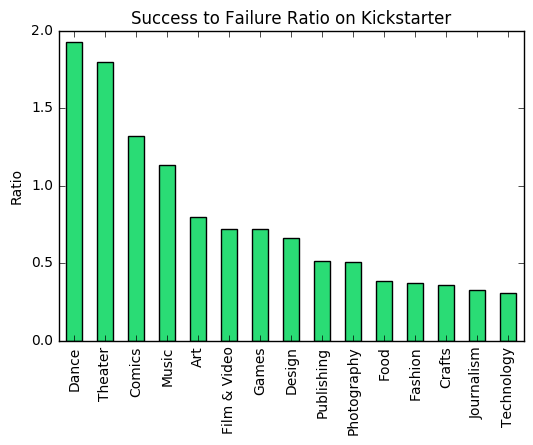

In [20]:
catPivot = kick.pivot_table(index='main_category', columns='state', values='ID', aggfunc='count')
catPivot['WLratio'] = catPivot['successful'] / catPivot['failed']
catPivot['WLratio'].sort_values(ascending=False).plot(kind='bar', color='#2ADC75')
plt.title('Success to Failure Ratio on Kickstarter')
plt.xlabel('')
plt.ylabel('Ratio')

Finally, let's create a comprehensive visualization that maps project outcomes across all categories.

In [21]:
#First, turn our pivot table columns into percentages instead of absolute numbers
catPivot = kick.pivot_table(index='main_category', columns='state', values='ID', aggfunc='count')
catPivot['total'] = catPivot.sum(axis=1)

In [22]:
#Change all columns to percentages of total
for column in catPivot.columns[:5]:
    catPivot[column] = catPivot[column] / catPivot['total']

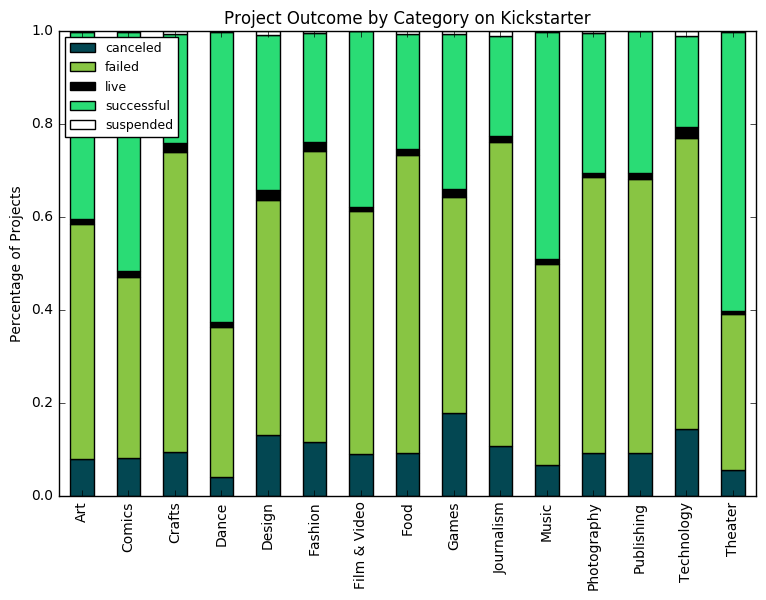

In [23]:
#Plot
catPivot.iloc[:,:5].plot(kind='bar', stacked=True, figsize=(9,6), 
                         color=['#034752', '#88C543', 'black','#2ADC75', 'white'])
plt.title('Project Outcome by Category on Kickstarter')
plt.legend(loc=2, prop={'size': 9})
plt.xlabel('')
plt.ylabel('Percentage of Projects')

## Prediction – What Drives Successful Projects?

Imagine you're starting out on the Kickstarter platform and want to make sure that your project has the highest possible chance of success. What do you do?

There are a number of ways we can approach this as a prediction problem:

* Classification: what drives a "success" in the state column?
* Regression: what drives highest "pledged" values?
* Regression: what drives the highest number of backers?

We'll run through all of these and see what kinds of accuracy we can achieve. Which model is right for any given situation depends on what the creator is optimizing for.

### Classification

Some relevant features might be: 

* category
* main_category
* goal
* country

There's also some potential to mind project names for words that correlate with success. We'll try a few different algorithms and see which gets the best accuracy: Logistic Regression, Decision Trees, and Naive Bayes. 

First, let's encode our categorical variables.

In [24]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

kickML = kick.copy()
for column in ['category', 'main_category','country']:
    kickML[column] = enc.fit_transform(kickML[column])

Since we're really only interested in success, we'll narrow down the dataset to only two outcomes – success and failure.

In [25]:
kickML = kickML[kickML['state'].apply(lambda x: x in ['successful', 'failed'])]

We'll also split the data into train, test, and cross validation sets (70% train, 15% each test and CV).

In [26]:
from sklearn.utils import shuffle
kickML = shuffle(kickML)

In [27]:
def dataSplit(features, target):
    trainx = kickML.iloc[:223526][features]
    trainy = kickML.iloc[:223526][target]
    testx = kickML.iloc[223527:271425][features]
    testy = kickML.iloc[223527:271425][target]
    cvx = kickML.iloc[271426:len(kickML)][features]
    cvy = kickML.iloc[271426:len(kickML)][target]
    
    return trainx, trainy, testx, testy, cvx, cvy

In [28]:
trainx, trainy, testx, testy, cvx, cvy = dataSplit(['category', 'main_category', 'goal', 'country'], 'state')

#### Logistic Regression

We'll start with Logistic Regression.

In [29]:
from sklearn import linear_model
model = linear_model.LogisticRegression()

In [30]:
model.fit(trainx, trainy)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We'll define a function for confusion matrix analysis, since we'll use it a few times.

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
def printCM(y,y_pred):
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    print("True positives: " + str(tp))
    print("False positives: " + str(fp))
    print("True negatives: " + str(tn))
    print("False negatives: " + str(fn))
    print('\n')
    print("Overall accuracy: " + str((tp+tn)/float((tp+tn+fp+fn))))
    print("Precision (tp/tp+fp): " + str(tp/float((tp+fp))))
    print("Recall (tp/tp+fn): " + str(tp/float((tp+fn))))

In [33]:
printCM(trainy, model.predict(trainx))

True positives: 0
False positives: 0
True negatives: 133874
False negatives: 89652


Overall accuracy: 0.598919141397
Precision (tp/tp+fp): nan
Recall (tp/tp+fn): 0.0


/Users/gagejustins/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


Our model is predicting exclusively "failed." This is strange, especially considering we don't have an imbalanced data set: 

In [34]:
kickML['state'].value_counts()['failed'] / float(len(kickML))

0.59807747724030469

Let's try a decision tree (or a few).

#### Decision Tree Classifier

In [35]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

In [36]:
clf = clf.fit(trainx, trainy)

In [37]:
printCM(trainy, clf.predict(trainx))

True positives: 51866
False positives: 20941
True negatives: 112933
False negatives: 37786


Overall accuracy: 0.737269937278
Precision (tp/tp+fp): 0.712376557199
Recall (tp/tp+fn): 0.57852585553


Training accuracy is a respectable 73%, but both precision and recall are lower than that number.

In [38]:
printCM(cvy, clf.predict(cvx))

True positives: 1879
False positives: 1306
True negatives: 4460
False negatives: 2018


Overall accuracy: 0.656007451102
Precision (tp/tp+fp): 0.589952904239
Recall (tp/tp+fn): 0.48216576854


In [39]:
printCM(testy, clf.predict(testx))

True positives: 9129
False positives: 6489
True negatives: 21983
False negatives: 10297


Overall accuracy: 0.649546953944
Precision (tp/tp+fp): 0.584517864003
Recall (tp/tp+fn): 0.46993719757


Accuracy on the test set is less encouraging. Let's try a few ensemble models.

#### Random Forest Classifier

The Random Forest randomly selects a subset of features to decide on splits – the auto setting is m = sqrt(p).

In [40]:
from sklearn.ensemble import RandomForestClassifier
clfF = RandomForestClassifier(random_state=0, n_estimators=100)

In [41]:
clfF.fit(trainx, trainy)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [42]:
printCM(cvy, clfF.predict(cvx))

True positives: 1964
False positives: 1365
True negatives: 4401
False negatives: 1933


Overall accuracy: 0.658698126876
Precision (tp/tp+fp): 0.589966957044
Recall (tp/tp+fn): 0.503977418527


In [43]:
printCM(testy, clfF.predict(testx))

True positives: 9553
False positives: 6761
True negatives: 21711
False negatives: 9873


Overall accuracy: 0.652720364107
Precision (tp/tp+fp): 0.585570675493
Recall (tp/tp+fn): 0.491763615773


The random forest accuracy looks almost identical to the single decision tree on both the cross validation and test sets.

#### Bagged Decision Tree Classifier

Bagging is the process of bootstrapping samples from the training set to create new training sets, and modeling each one individually. Predictions are then averaged together from each model for a given sample.

In [44]:
from sklearn.ensemble import BaggingClassifier
bclf = BaggingClassifier(n_estimators=100)

In [45]:
bclf.fit(trainx, trainy)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [46]:
printCM(cvy, bclf.predict(cvx))

True positives: 1965
False positives: 1369
True negatives: 4397
False negatives: 1932


Overall accuracy: 0.658387664286
Precision (tp/tp+fp): 0.589382123575
Recall (tp/tp+fn): 0.504234026174


In [47]:
printCM(testy, bclf.predict(testx))

True positives: 9543
False positives: 6791
True negatives: 21681
False negatives: 9883


Overall accuracy: 0.651885256169
Precision (tp/tp+fp): 0.584241459532
Recall (tp/tp+fn): 0.491248841758


As with the Random Forest Classifier, we achieve similar results to the single decision tree.

#### Naive Bayes Classifier

Let's try a classic, the Naive Bayes Classifier.

In [48]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [49]:
printCM(trainy, gnb.fit(trainx, trainy).predict(trainx))

True positives: 88681
False positives: 125473
True negatives: 8401
False negatives: 971


Overall accuracy: 0.434320839634
Precision (tp/tp+fp): 0.414099199641
Recall (tp/tp+fn): 0.989169232142


Overall accuracy is much lower than other models, but recall is extremely high with a value of 99%. The same holds true for the test set:

In [50]:
printCM(testy, gnb.fit(testx, testy).predict(testx))

True positives: 19103
False positives: 26132
True negatives: 2340
False negatives: 323


Overall accuracy: 0.447680487703
Precision (tp/tp+fp): 0.422305736708
Recall (tp/tp+fn): 0.983372799341


The Naive Bayes model is very trigger happy – there's a very high false positive ratio (more than true positives) compared to the false negative ratio (far fewer than true negatives).

### Regression

The feature set should be largely similar, but instead of trying to predict a binary (success/failure) we'll look at a different target variable: money pledged as a percentage of the goal. This is a better target variable than absolute money raised, since it is normalized by the goal.

We'll start by creating a column for percentage of goal achieved to use as our target variable.

In [51]:
kickML['completion'] = kickML['pledged'] / kickML['goal']

And now, as above, we'll split our data into train, test, and cross validation.

In [52]:
trainx, trainy, testx, testy, cvx, cvy = dataSplit(['category', 'main_category', 'goal', 'country'], 'completion')

#### Linear Regression

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
import sklearn.metrics as m
lr = LinearRegression()

In [54]:
model = lr.fit(trainx, trainy)

Let's define a function to analyze metrics for our regressions.

In [55]:
def regScore(trainy, predy):
    print("R^2: " + str(m.r2_score(trainy, predy)))
    print("MSE: " + str(m.mean_squared_error(trainy, predy)))
    print("MAE: " + str(m.mean_absolute_error(trainy, predy)))

In [56]:
regScore(trainy, model.predict(trainx))

R^2: 2.13129179943e-05
MSE: 78241.1130696
MAE: 5.46844358297


An R^2 of sub 1% is not very good. Let's take a look at the coefficients and their significance levels:

In [57]:
pd.DataFrame({'coefficient': model.coef_, 
              'F-score': f_regression(trainx, trainy)[0], 
              'p-value': f_regression(trainx, trainy)[1]},
            index = trainx.columns)

,F-score,coefficient,p-value
category,2.33,0.02,0.13
main_category,0.02,-0.02,0.89
goal,0.05,-0.00,0.83
country,2.32,0.17,0.13


The category and country features have p-values of around .10, which is above the traditional .05 threshold but still means that they have non-trivial predictive power for completion. Interestingly enough, the size of the goal has no discernable impact on whether it will be achieved or not.

#### Decision Tree Regressor

In [58]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()

In [59]:
dtr.fit(trainx, trainy)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [60]:
regScore(trainy, dtr.predict(trainx))

R^2: 0.24609176982
MSE: 58987.8762854
MAE: 3.15522624416


In [61]:
regScore(testy, dtr.predict(testx))

R^2: -0.397734361351
MSE: 91519.1639112
MAE: 6.06126565291


This decision tree achieves a much better R^2 of 22%, but has a negative R^2 value on the test set, which means the model is heavily overfitting. To address that and lower the variance, we can try a Random Forest Regressor.

#### Random Forest Regressor

In [62]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100)

In [63]:
rfr.fit(trainx, trainy)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [64]:
regScore(trainy, rfr.predict(trainx))

R^2: 0.228082446677
MSE: 60396.9758058
MAE: 3.6324661383


In [65]:
regScore(testy, rfr.predict(testx))

R^2: 0.00177124895839
MSE: 65360.81763
MAE: 5.32954442731


The Random Forest's R^2 for the test set is still abysmal. Let's plot how our key metrics change as we vary some of the parameters in this decision tree.

In [100]:
def graphRFRR2(x, y):
    
    #For adjusting max_depth
    rsmax_depth = []
    for depth in np.arange(2,112, 10):
        rfr = RandomForestRegressor(max_depth=depth, n_estimators=10)
        rsmax_depth.append(m.r2_score(y, rfr.fit(trainx, trainy).predict(x)))
        
    #For adjusting max_lead_nodes
    rsmax_leaf_nodes = []
    for nodes in np.arange(2,112, 10):
        rfr = RandomForestRegressor(max_leaf_nodes=nodes, n_estimators=10)
        rsmax_leaf_nodes.append(m.r2_score(y, rfr.fit(trainx, trainy).predict(x)))
   
    return pd.DataFrame({'max_depth': rsmax_depth, 'max_leaf_nodes': rsmax_leaf_nodes}, index=np.arange(2,112,10))

In [101]:
plotR = graphRFRR2(trainx, trainy)

(0, 1)

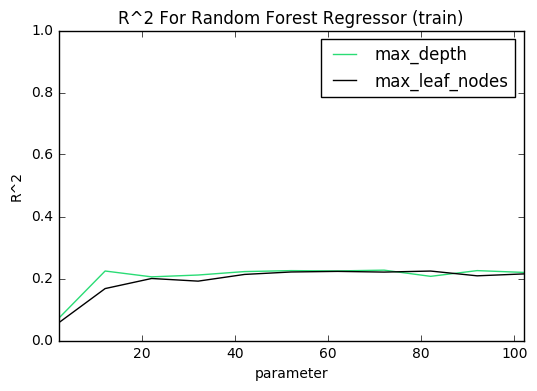

In [102]:
plotR.plot(color=['#2ADC75', 'black'])
plt.title('R^2 For Random Forest Regressor (train)')
plt.xlabel('parameter')
plt.ylabel('R^2')
plt.ylim(0,1)

In [103]:
plotR = graphRFRR2(cvx, cvy)

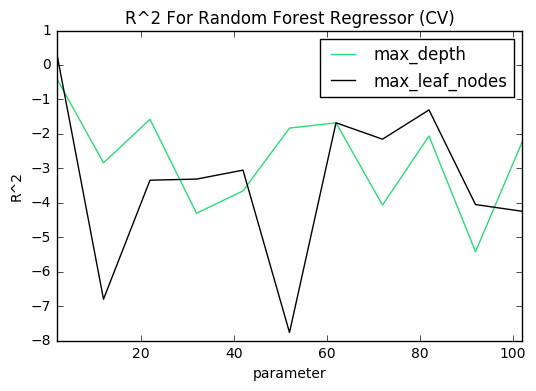

In [105]:
plotR.plot(color=['#2ADC75', 'black'])
plt.title('R^2 For Random Forest Regressor (CV)')
plt.xlabel('parameter')
plt.ylabel('R^2')

Varying the max_depth and max_leaf_nodes do nothing to achieve an acceptable R^2 score. Unfortunately, our model isn't very predictive at all. To verify our graph / findings, we can use sklearn's GridSearchCV method to optimize these two parameters. The resulting R^2 will be the best we can do.

In [106]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth': [1,11,21,31,41,51], 
             'max_leaf_nodes': [2,22,32,42,52]}
rfr = RandomForestRegressor(n_estimators=25)

In [107]:
model = GridSearchCV(rfr, parameters, scoring='r2')
model.fit(trainx, trainy)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_leaf_nodes': [2, 22, 32, 42, 52], 'max_depth': [1, 11, 21, 31, 41, 51]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [108]:
model.best_score_

0.019184883442790412

## Summary / Conclusion

Overall, we were able to achieve mediocre accuracy on our prediction tasks. Our classifier maxed out at around 67%, but our regressions weren't able to achieve meaningful prediction precision.

Some ideas to improve our prediction accuracy across both classification and regression:

* Mine project names for new features
* Gather new informative data like a project description and attached images
* More complex algorithms